## Import Libraries

In [8]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [9]:
df = pd.read_csv(r"C:\Users\labbo\OneDrive\Desktop\BootTuwaiq\week3\Usecase-7\cleaned_data_football.csv")

In [10]:
df.shape

(10754, 19)

In [11]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [12]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]
df = df.drop('Unnamed: 0', axis=1)


In [17]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [14]:
# Accurecy types
df.dtypes

team                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

In [18]:
categorical_features = ['team', 'position']
numeric_features = ['highest_value', 'current_value', 'games_injured',
'days_injured','minutes played','clean sheets','goals conceded',
'red cards','second yellow cards','yellow cards','assists','goals','appearance','age','height']

In [19]:
for i in categorical_features:
    print (df[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1821
Attack Centre-Forward         1353
Goalkeeper                    1229
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     900
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     769
Attack-RightWinger             717
Attack-LeftWinger              714
midfield-RightMidfield         102
midfield-LeftMidfield          100
midfield                        75
Attack-SecondStriker            65
Attack                          53
Defender                        33
Name: count, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [20]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000


In [21]:
categorical_features

['team', 'position']

In [22]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [23]:
df.shape

(10754, 406)

In [24]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,...,False,False,False,True,False,False,False,False,False,False
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,...,False,False,False,True,False,False,False,False,False,False


In [25]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(current_value):
    if current_value < p35:
        return 'Cheap_Price'
    elif current_value < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['player_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['player_price_category'].value_counts())

player_price_category
Good_Price     4310
Cheap_Price    3754
High_Price     2690
Name: count, dtype: int64


In [26]:
p35, p75

(450000.0, 3000000.0)

In [27]:
encoder = LabelEncoder()
df['player_price_category_encoded'] = encoder.fit_transform(df['player_price_category'])  

#### 3. Feature selection

In [28]:
correlation = df.corr(numeric_only=True)
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['player_price_category_encoded'].sort_values(ascending=False))

player_price_category_encoded    1.000000
appearance                       0.546979
minutes played                   0.519476
highest_value                    0.488265
award                            0.242359
                                   ...   
team_Royal AM FC                -0.067733
position_Attack                 -0.082597
position_midfield               -0.096901
goals conceded                  -0.128555
position_Goalkeeper             -0.172988
Name: player_price_category_encoded, Length: 406, dtype: float64


In [30]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['player_price_category_encoded']) > \
threshold]['player_price_category_encoded'].index
selected_features

Index(['appearance', 'minutes played', 'games_injured', 'award',
       'highest_value', 'player_price_category_encoded'],
      dtype='object')

In [31]:
selected_features = ['appearance', 'minutes played', 'games_injured', 'award',
       'highest_value', 'player_price_category_encoded']

In [32]:
df = df[selected_features]
df.head()

,appearance,minutes played,games_injured,award,highest_value,player_price_category_encoded
0,104,9390,5,13,70000000,2
1,15,1304,58,1,22000000,1
2,4,292,84,4,6000000,1
3,82,6408,22,9,50000000,2
4,63,5031,51,21,80000000,2


#### 4. Prepare train and test data

In [33]:
# Prepare data
X = df.drop(['player_price_category_encoded'], axis=1)
y = df['player_price_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
X.shape

(10754, 5)

## Buliding the Model

In [35]:
svm_classifier = SVC() 

In [36]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[0, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=svm_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [37]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 2, 5, 10, 15, 20, 25], 'gamma': [1, 2, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [38]:
grid_search.best_params_

{'C': 20, 'gamma': 1, 'kernel': 'rbf'}

In [39]:
model = grid_search.best_estimator_

## Test the Model

In [40]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [41]:
# our benchmark model
base_model = round(df['player_price_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

40.08

1. Accuracy

In [42]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7656903765690377

In [43]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.8433104730907823

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[593, 150,  13],
       [135, 646, 101],
       [  5, 100, 408]], dtype=int64)

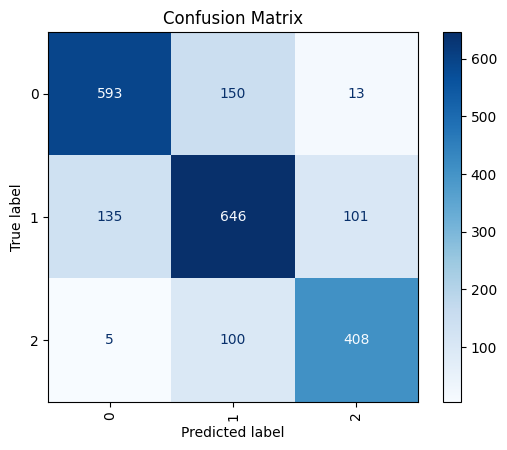

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [46]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.77


In [47]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.77


In [48]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.77


In [49]:
print(classification_report(y_test,
                      y_pred,
                      labels=list(model.classes_)))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       756
           1       0.72      0.73      0.73       882
           2       0.78      0.80      0.79       513

    accuracy                           0.77      2151
   macro avg       0.77      0.77      0.77      2151
weighted avg       0.77      0.77      0.77      2151



In [ ]:
#Thank You